In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# ignore imputation warnings from pymc
# ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
import warnings
from pymc import ImputationWarning

warnings.filterwarnings("ignore", category=ImputationWarning)

In [13]:
import numpy as np
import pymc as pm
import arviz as az
from birdcall_distribution.data import prepare_dataframe, prepare_scaled_data
from birdcall_distribution.plot import plot_species, plot_ppc_species

prep_df, W = prepare_dataframe(
    "../data/ee_v3_western_us_2.parquet",
    "../data/raw/birdclef-2022/train_metadata.csv",
    n_species=3,
)
prep_df.head()

,primary_label,grid_id,y,region,grid_size,population_density,elevation_p5,elevation_p50,elevation_p95,LST_Day_1km_p5,...,land_cover_08,land_cover_09,land_cover_10,land_cover_11,land_cover_12,land_cover_13,land_cover_14,land_cover_15,land_cover_16,land_cover_17
adjacency_idx,,,,,,,,,,,,,,,,,,,,,
0,other,-103_37,9.0,western_us,2,59513.489132,917.473286,1113.467367,1389.580957,25.930530,...,0,0,25124,0,13749,9,0,0,10,10
0,normoc,-103_37,3.0,western_us,2,59513.489132,917.473286,1113.467367,1389.580957,25.930530,...,0,0,25124,0,13749,9,0,0,10,10
0,wesmea,-103_37,2.0,western_us,2,59513.489132,917.473286,1113.467367,1389.580957,25.930530,...,0,0,25124,0,13749,9,0,0,10,10
0,houfin,-103_37,NaN,western_us,2,59513.489132,917.473286,1113.467367,1389.580957,25.930530,...,0,0,25124,0,13749,9,0,0,10,10
1,normoc,-103_39,NaN,western_us,2,72311.465983,933.400010,1109.527419,1373.500000,23.530828,...,0,0,26593,1,11191,14,0,0,5,5


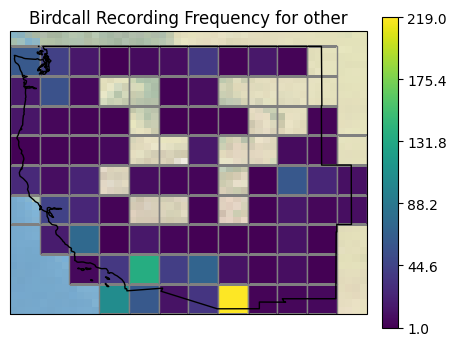

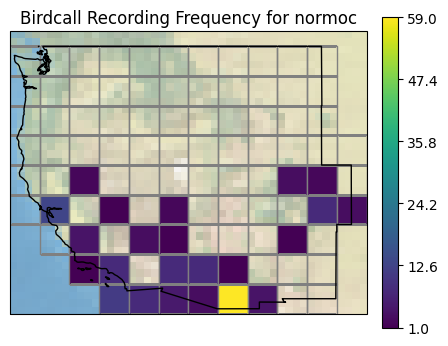

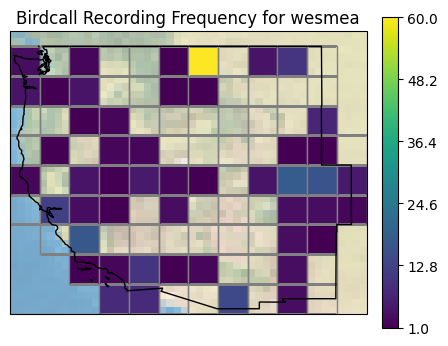

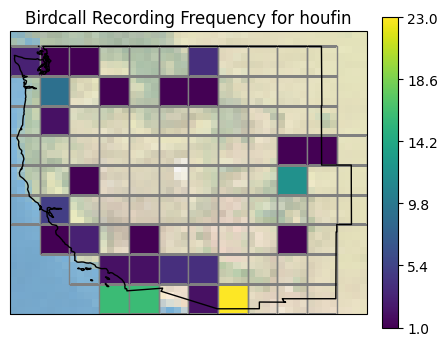

In [14]:
for species in prep_df.primary_label.unique():
    plot_species(prep_df, species)

## model

### varying intercept and slope

\begin{equation}
y_i = \alpha_{j[i]} + \beta_{j[i]} x_i + \epsilon_i
\end{equation}

## 

In [15]:
prep_df.columns

Index(['primary_label', 'grid_id', 'y', 'region', 'grid_size',
       'population_density', 'elevation_p5', 'elevation_p50', 'elevation_p95',
       'LST_Day_1km_p5', 'LST_Day_1km_p50', 'LST_Day_1km_p95',
       'LST_Night_1km_p5', 'LST_Night_1km_p50', 'LST_Night_1km_p95',
       'land_cover_01', 'land_cover_02', 'land_cover_03', 'land_cover_04',
       'land_cover_05', 'land_cover_06', 'land_cover_07', 'land_cover_08',
       'land_cover_09', 'land_cover_10', 'land_cover_11', 'land_cover_12',
       'land_cover_13', 'land_cover_14', 'land_cover_15', 'land_cover_16',
       'land_cover_17'],
      dtype='object')

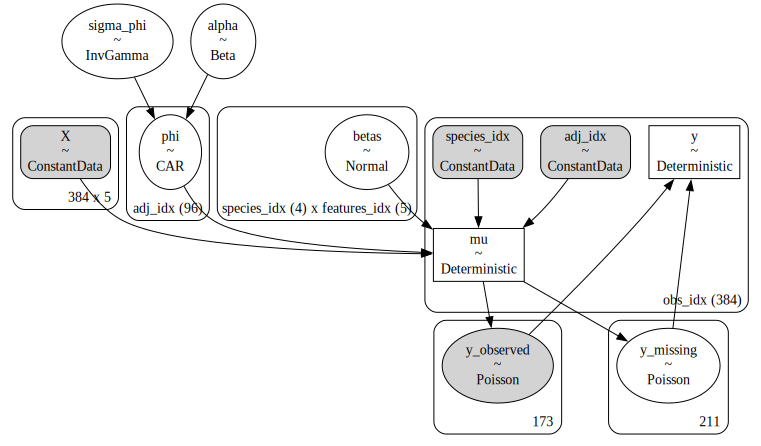

In [25]:
data_cols = [
    "population_density",
    "elevation_p50",
    "LST_Day_1km_p95",
    "LST_Night_1km_p5",
]
scaled_data_df = prepare_scaled_data(
    prep_df, data_cols, ["population_density"], intercept=False
)

species_cat = prep_df.primary_label.astype("category")
n_features = scaled_data_df.shape[1]
n_species = len(species_cat.cat.categories)
coords = dict(
    features_idx=np.arange(n_features),
    species_idx=sorted(species_cat.cat.codes.unique()),
    adj_idx=sorted(prep_df.index.unique()),
    obs_idx=np.arange(prep_df.shape[0]),
)
with pm.Model(coords=coords) as full_model:
    species_idx = pm.ConstantData("species_idx", species_cat.cat.codes, dims="obs_idx")
    adj_idx = pm.ConstantData("adj_idx", prep_df.index.values, dims="obs_idx")
    X = pm.ConstantData("X", scaled_data_df.values)

    alpha = pm.Beta("alpha", 5, 1)
    sigma_phi = pm.InverseGamma("sigma_phi", 0, 0.01)
    phi = pm.CAR(
        "phi", mu=np.zeros(W.shape[0]), tau=sigma_phi, alpha=alpha, W=W, dims="adj_idx"
    )
    intercept = pm.Normal("intercept", mu=0, tau=1e-4)
    betas = pm.Normal(
        "betas",
        mu=0,
        tau=1e-4,
        dims=("species_idx", "features_idx"),
    )
    mu = pm.Deterministic(
        "mu",
        pm.math.exp(
            intercept + pm.math.sum(X * betas[species_idx], axis=1) + phi[adj_idx]
        ),
        dims="obs_idx",
    )

    observed = np.ma.masked_invalid(prep_df.y.values)
    pm.Poisson("y", mu=mu, observed=observed, dims="obs_idx")

pm.model_to_graphviz(full_model)

In [18]:
with full_model:
    trace_full = pm.sample(1000, cores=8, target_accept=0.8)

Multiprocess sampling (8 chains in 8 jobs)
CompoundStep
>NUTS: [alpha, phi, betas]
>Metropolis: [y_missing]


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 1067 seconds.


In [19]:
az.summary(trace_full, kind="stats", var_names=["~phi", "~y", "~mu"])

,mean,sd,hdi_3%,hdi_97%
"betas[0, 0]",2.477,4.843,-6.529,11.428
"betas[0, 1]",3.336,7.841,-10.829,17.863
"betas[0, 2]",0.039,6.605,-13.379,12.050
"betas[0, 3]",3.390,9.279,-12.686,19.963
"betas[0, 4]",0.217,99.363,-194.284,180.984
...,...,...,...,...
y_missing[207],2.927,2.109,0.000,7.000
y_missing[208],3.428,2.352,0.000,8.000
y_missing[209],15.468,7.212,2.000,28.000
y_missing[210],49.813,23.601,11.000,95.000


array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

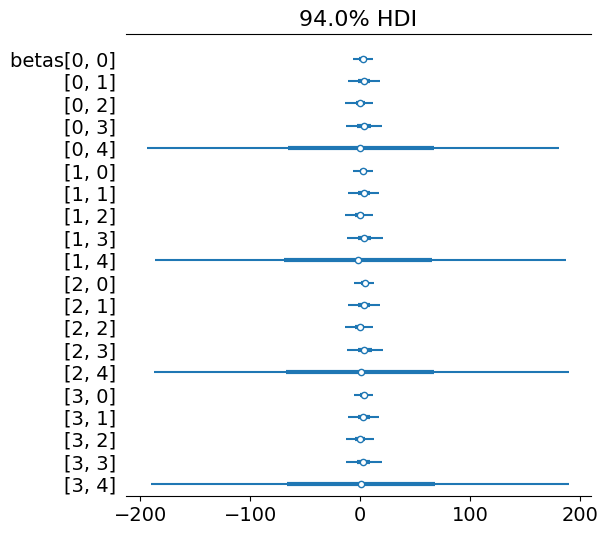

In [23]:
az.plot_forest(trace_full, var_names=["betas"], combined=True)

Sampling: [y_observed]


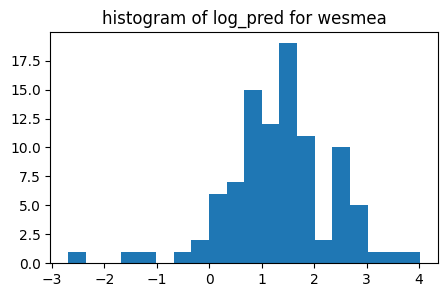

              primary_label  grid_id      pred  log_pred
adjacency_idx                                           
0                    wesmea  -103_37   5.78050  1.754490
1                    wesmea  -103_39  11.68825  2.458584
2                    wesmea  -103_41   3.90750  1.362898
3                    wesmea  -105_31   3.44550  1.237069
4                    wesmea  -105_33   2.15350  0.767094
...                     ...      ...       ...       ...
91                   wesmea  -125_39   5.09300  1.627867
92                   wesmea  -125_41   0.75450 -0.281700
93                   wesmea  -125_43   2.51150  0.920880
94                   wesmea  -125_45   4.47725  1.499009
95                   wesmea  -125_47  10.55550  2.356647

[96 rows x 4 columns]


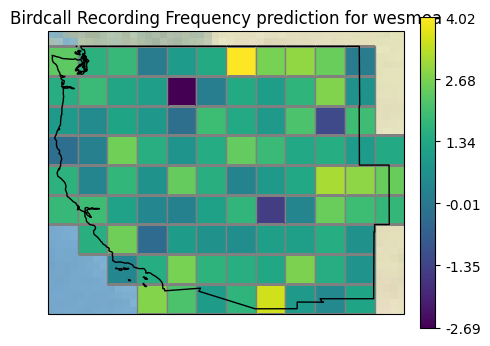

In [343]:
with full_model:
    ppc_full = pm.sample_posterior_predictive(trace_full)

plot_ppc(prep_df, ppc_full, "wesmea", "log_pred")